In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, f1_score, 
                             precision_score, recall_score, accuracy_score, 
                             roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
# Import LightGBM
from lightgbm import LGBMClassifier

In [3]:
#-----------------------------------------
# 1. Load Data
#-----------------------------------------
train_data = pd.read_parquet('./data/train_scaled.parquet')
test_data = pd.read_parquet('./data/test_scaled.parquet')

In [4]:
#-----------------------------------------
# 2. Train/Test Split
#-----------------------------------------
# Separate features and target
X_train = train_data.drop(['class'], axis=1, errors='ignore') 
y_train = train_data['class']

In [5]:
# Separate features and target
X_test = test_data.drop(['class'], axis=1, errors='ignore') 
y_test = test_data['class']

In [6]:
# 3. Handle Class Imbalance (SMOTE)
#-----------------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#-----------------------------------------
# 4. Define Model & Parameter Grid
#    Using LightGBM now
#-----------------------------------------
model = LGBMClassifier(random_state=42)

param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 300]
}


In [7]:
# 5. Hyperparameter Tuning using GridSearchCV with progress
#    Set verbose=3 to see detailed progress.
#-----------------------------------------
grid = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=3)
grid.fit(X_train_res, y_train_res)

best_model = grid.best_estimator_
print(f"Best params for LightGBM: {grid.best_params_}\n")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 108540, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3872
[LightGBM] [Info] Number of data points in the train set: 217080, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best params for LightGBM: {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 63}



In [9]:
#-----------------------------------------
# 6. Evaluate the Best Model with Runtime Profiling for Fitting and Prediction
#-----------------------------------------
model_performance = []

# Measure training time
import time
start_fit = time.time()
best_model.fit(X_train_res, y_train_res)  # Refit model for fair timing
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_predict = time.time()
y_pred = best_model.predict(X_test)
end_predict = time.time()
predict_time = end_predict - start_predict

# Metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

model_performance.append({
    "Model": "LightGBM",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Training Time (s)": fit_time,
    "Prediction Time (s)": predict_time
})

print(f"LightGBM - Training Time: {fit_time:.4f} s, Prediction Time: {predict_time:.4f} s")
print("----------------------------------------------------\n")

[LightGBM] [Info] Number of positive: 108540, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3872
[LightGBM] [Info] Number of data points in the train set: 217080, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM - Training Time: 2.1654 s, Prediction Time: 0.1349 s
----------------------------------------------------



      Model  Accuracy  Precision    Recall  F1-Score  Training Time (s)  \
0  LightGBM  0.955913   0.998657  0.530125  0.692594           2.165359   

   Prediction Time (s)  
0             0.134866  


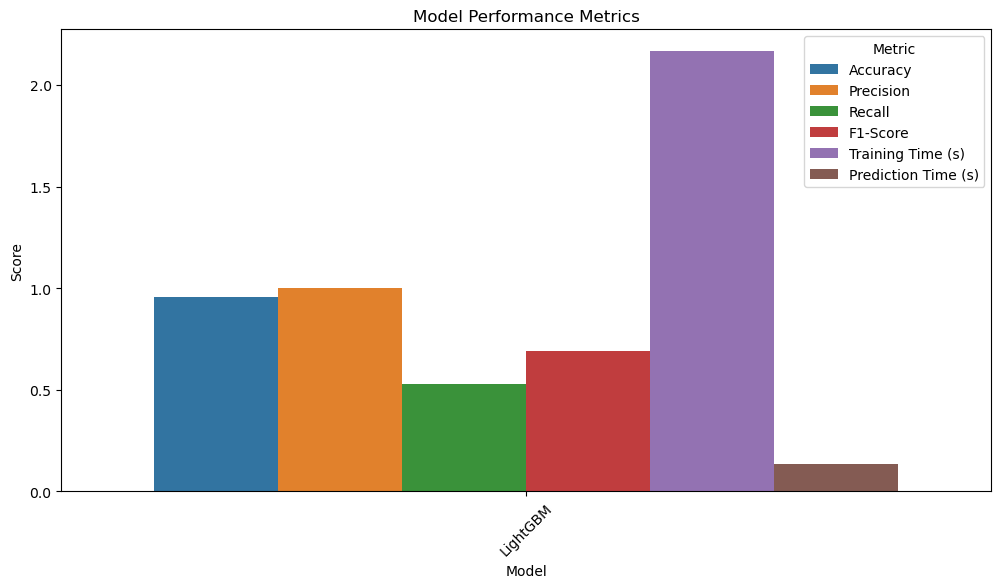

In [10]:
#-----------------------------------------
# 7. Visualize Metrics and Runtime
#-----------------------------------------
# Convert model performance to DataFrame
df_performance = pd.DataFrame(model_performance)

# Display performance
print(df_performance)

# Visualization of metrics
plt.figure(figsize=(12, 6))
sns.barplot(data=df_performance.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Model', y='Score', hue='Metric')
plt.title("Model Performance Metrics")
plt.xticks(rotation=45)
plt.show()

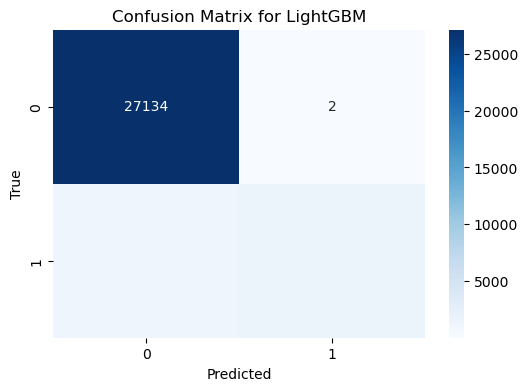

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for LightGBM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

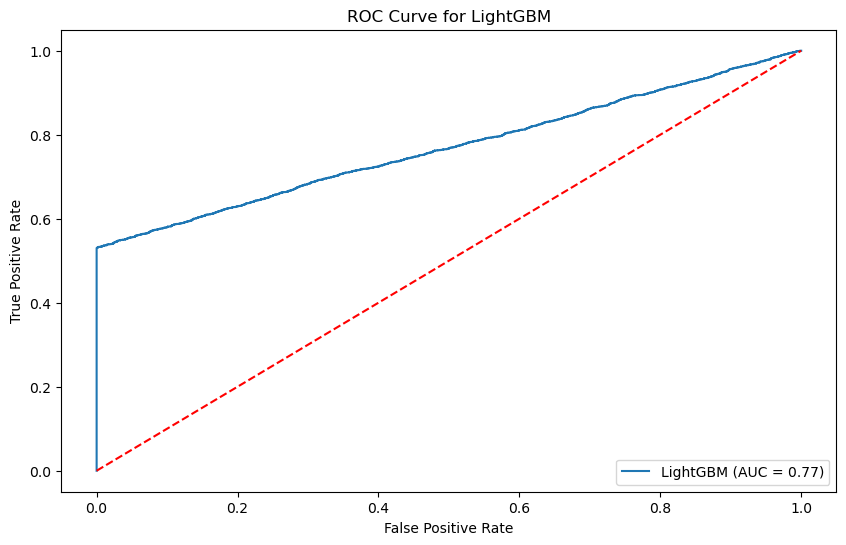

In [12]:
# ROC Curve
plt.figure(figsize=(10, 6))
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
else:
    y_proba = best_model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve for LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

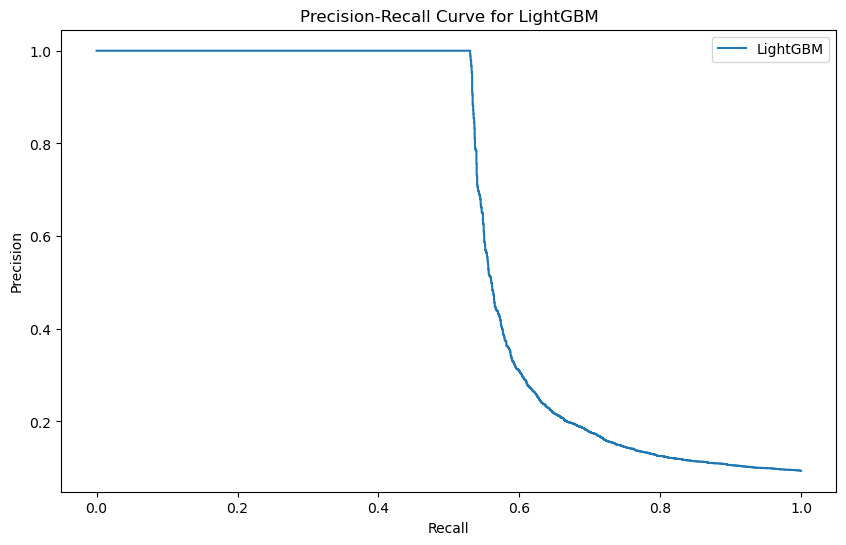

In [13]:
# Precision-Recall Curve
precision_pts, recall_pts, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall_pts, precision_pts, label="LightGBM")
plt.title("Precision-Recall Curve for LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

In [14]:
# Determine best model based on F1-score
best_model = max(model_performance, key=lambda x: x['F1-Score'])
print("Best Model based on F1-score is:", best_model["Model"], "with F1-score:", best_model["F1-Score"])
print("Accuracy for best model:", best_model["Accuracy"])

Best Model based on F1-score is: LightGBM with F1-score: 0.6925943176525384
Accuracy for best model: 0.9559132961490933
